
# Real-World Example: Conformal Prediction on Renin Inhibitor Data

This notebook demonstrates robust benchmarking of conformal prediction (CP) methods on a real molecular dataset (`renin_harren.csv`). We compare CP to standard uncertainty quantification (UQ) methods and ML models, using advanced metrics. All steps are NaN-safe and ready for direct use.


In [2]:

## 1. Import Required Libraries and Define Utility Functions
import numpy as np
import pandas as pd
from molpipeline.any2mol import SmilesToMol
from molpipeline.error_handling import ErrorFilter, FilterReinserter
from molpipeline.mol2any.mol2morgan_fingerprint import MolToMorganFP
from molpipeline.pipeline import Pipeline
from molpipeline.post_prediction import PostPredictionWrapper
from molpipeline.experimental.uncertainty.conformal import UnifiedConformalCV, CrossConformalCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (
    log_loss, brier_score_loss, balanced_accuracy_score, roc_auc_score,
    average_precision_score, f1_score, matthews_corrcoef
)
import matplotlib.pyplot as plt

def compute_ece(y_true, probs, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(probs, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            acc = np.mean(y_true[mask] == (probs[mask] >= 0.5))
            conf = np.mean(probs[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

def compute_uncertainty_error_corr(y_true, probs):
    eps = 1e-12
    entropy = -probs * np.log(probs + eps) - (1 - probs) * np.log(1 - probs + eps)
    error = np.abs(y_true - (probs >= 0.5))
    return np.corrcoef(entropy, error)[0, 1]

def compute_sharpness(probs):
    eps = 1e-12
    entropy = -probs * np.log(probs + eps) - (1 - probs) * np.log(1 - probs + eps)
    return np.mean(entropy)



In [3]:


## 2. Data Loading, Cleaning, and Featurization
# Load real data
df = pd.read_csv("example_data/renin_harren.csv")
smiles = df["pubchem_smiles"].values
y_reg = df["pIC50"].values

# Binarize for classification: top 20% as 'active'
threshold = np.nanquantile(y_reg, 0.8)
y_class = (y_reg >= threshold).astype(int)

# Featurization pipeline (NaN-safe)
error_filter = ErrorFilter(filter_everything=True)
error_replacer = FilterReinserter.from_error_filter(error_filter, fill_value=np.nan)
featurizer = Pipeline([
    ("smi2mol", SmilesToMol()),
    ("error_filter", error_filter),
    ("morgan", MolToMorganFP(radius=2, n_bits=256, return_as="dense")),
    ("error_replacer", PostPredictionWrapper(error_replacer)),
], n_jobs=1)
X_feat = featurizer.transform(smiles)

print(f"Shape of X={X_feat.shape}, y_class={y_class.shape}, y_reg={y_reg.shape}")



## 3. Classification: Splitting, Model Benchmarking, and Conformal Prediction
# Train/test split for classification
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y_class, test_size=0.3, random_state=42, stratify=y_class
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split for conformal pipeline (use SMILES)
smiles_train, smiles_test, y_train_cp, y_test_cp = train_test_split(
    smiles, y_class, test_size=0.3, random_state=42, stratify=y_class
)




Shape of X=(138, 256), y_class=(138,), y_reg=(138,)


In [4]:

### 3.1 Benchmarking Standard Models

from xgboost import XGBClassifier

model_dict = {
    "ensemble_xgb": XGBClassifier(eval_metric='logloss', random_state=42),
}
metrics_list = [
    "NLL", "ECE", "Brier", "Uncertainty Error Correlation", "Sharpness",
    "Balanced Accuracy", "AUROC", "AUPRC", "F1 Score", "MCC"
]
results = []

for model_name, model in model_dict.items():
    probs = []
    preds = []
    for train_idx, _ in skf.split(X_train, y_train):
        model.fit(X_train[train_idx], y_train[train_idx])
        prob = model.predict_proba(X_test)
        pred = model.predict(X_test)
        probs.append(prob)
        preds.append(pred)
    probs = np.stack(probs)
    preds = np.stack(preds)
    mean_probs = probs.mean(axis=0)
    mean_pred = np.round(mean_probs[:, 1]).astype(int)
    y_true = y_test
    p1 = mean_probs[:, 1]
    metrics = {
        "Model": model_name,
        "NLL": log_loss(y_true, p1),
        "ECE": compute_ece(y_true, p1),
        "Brier": brier_score_loss(y_true, p1),
        "Uncertainty Error Correlation": compute_uncertainty_error_corr(y_true, p1),
        "Sharpness": compute_sharpness(p1),
        "Balanced Accuracy": balanced_accuracy_score(y_true, mean_pred),
        "AUROC": roc_auc_score(y_true, p1),
        "AUPRC": average_precision_score(y_true, p1),
        "F1 Score": f1_score(y_true, mean_pred),
        "MCC": matthews_corrcoef(y_true, mean_pred)
    }
    results.append(metrics)



### 3.2 Conformal Prediction (CrossConformalCV)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipeline = Pipeline([
    ("featurizer", featurizer),
    ("rf", rf)
], n_jobs=1)
cc_clf = CrossConformalCV(
    estimator=rf_pipeline,
    n_folds=5,
    confidence_level=0.9,
    estimator_type="classifier"
)
cc_clf.fit(smiles_train, y_train_cp)
probs_cp_ensemble = np.mean([m.predict_proba(smiles_test) for m in cc_clf.models_], axis=0)
mean_pred_cp = np.argmax(probs_cp_ensemble, axis=1)
y_true_cp = y_test_cp
p1_cp = probs_cp_ensemble[:, 1]
p1_cp = p1_cp / (p1_cp + (1 - p1_cp))  # Normalize to [0, 1]
metrics_cp = {
    "Model": "CrossConformalCV",
    "NLL": log_loss(y_true_cp, p1_cp),
    "ECE": compute_ece(y_true_cp, p1_cp),
    "Brier": brier_score_loss(y_true_cp, p1_cp),
    "Uncertainty Error Correlation": compute_uncertainty_error_corr(y_true_cp, p1_cp),
    "Sharpness": compute_sharpness(p1_cp),
    "Balanced Accuracy": balanced_accuracy_score(y_true_cp, mean_pred_cp),
    "AUROC": roc_auc_score(y_true_cp, p1_cp),
    "AUPRC": average_precision_score(y_true_cp, p1_cp),
    "F1 Score": f1_score(y_true_cp, mean_pred_cp),
    "MCC": matthews_corrcoef(y_true_cp, mean_pred_cp)
}
results.append(metrics_cp)

results_df = pd.DataFrame(results).set_index("Model").T
display(results_df)






Model,ensemble_xgb,CrossConformalCV
NLL,0.600558,0.452315
ECE,0.642123,0.553429
Brier,0.196583,0.150788
Uncertainty Error Correlation,0.203105,0.357254
Sharpness,0.329143,0.477957
Balanced Accuracy,0.686869,0.621212
AUROC,0.725589,0.771044
AUPRC,0.370320,0.441224
F1 Score,0.500000,0.400000
MCC,0.348793,0.284268


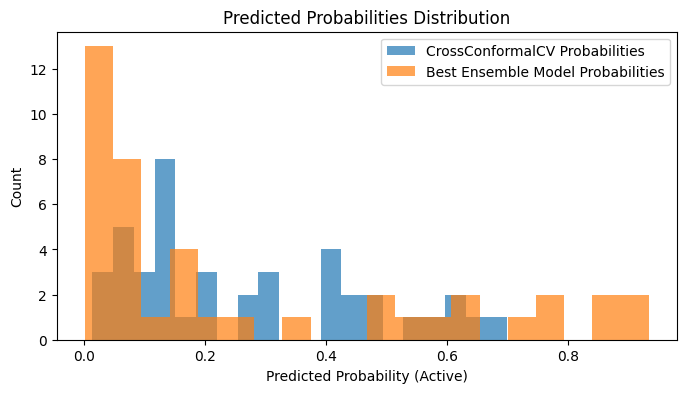

,SMILES,p0,p1,p1_norm,conformal_set,true_label
0,CC1=CC=CC=C1OC2=C(C3=C(N2C4=CC=CC=C4)N=CC=C3)C...,0.882059,0.046554,0.050133,"[0, 1]",0
1,C1CCN(CC1)C2=C(C3=CC=CC=C3N2C4=CC=CC=C4)C(=O)N...,0.625464,0.043202,0.064609,"[0, 1]",0
2,CC1=C(C=CC=C1F)CC2=C(C3=C(N2C4=CC=CC=C4)C=C(C=...,0.223852,0.302528,0.574733,[1],1
3,C1CN(CCN1)C(=O)C2=C(N(C3=C2N=CC=C3)C4=CC=CC=C4...,0.323485,0.234067,0.419812,[1],0
4,CC1=C(C=CC=C1F)CC2=C(C3=CN=C(C=C3N2C4CCCCC4)OC...,0.644347,0.057275,0.081632,"[0, 1]",0


Conformal set coverage: 0.833
Conformal set average size: 1.690
Conformal set error: 0.167
Fraction of empty sets: 0.000
NLL: 0.4487081892488713
Brier: 0.14933955252658113
AUROC: 0.771043771043771
F1: 0.42857142857142855
MCC: 0.34555798270379956


In [5]:
### 3.3 Visualizing Uncertainty and Prediction Sets

plt.figure(figsize=(8, 4))
plt.hist(p1_cp, bins=20, alpha=0.7, label="CrossConformalCV Probabilities")
plt.hist(p1, bins=20, alpha=0.7, label="Best Ensemble Model Probabilities")
plt.xlabel("Predicted Probability (Active)")
plt.ylabel("Count")
plt.legend()
plt.title("Predicted Probabilities Distribution")
plt.show()



# Get conformal prediction sets (list of sets per sample)
conf_pred_sets = cc_clf.predict_conformal_set(smiles_test, confidence=0.9)

# Get p-values for each class (p0, p1)
p_vals = cc_clf.models_[0].predict_p(smiles_test)
if hasattr(cc_clf, "models_") and len(cc_clf.models_) > 1:
    p_vals = np.mean([m.predict_p(smiles_test) for m in cc_clf.models_], axis=0)

p0 = p_vals[:, 0]
p1 = p_vals[:, 1]
p1_norm = p1 / (p0 + p1 + 1e-12)

df_cp_class = pd.DataFrame({
    "SMILES": smiles_test,
    "p0": p0,
    "p1": p1,
    "p1_norm": p1_norm,
    "conformal_set": conf_pred_sets,
    "true_label": y_test_cp
})
display(df_cp_class.head())

def coverage_and_set_size(y_true, conf_sets):
    covered = [y in s for y, s in zip(y_true, conf_sets)]
    avg_size = np.mean([len(s) for s in conf_sets])
    return np.mean(covered), avg_size

coverage, avg_set_size = coverage_and_set_size(y_test_cp, conf_pred_sets)
error = 1 - coverage
empty = np.mean([len(s) == 0 for s in conf_pred_sets])

print(f"Conformal set coverage: {coverage:.3f}")
print(f"Conformal set average size: {avg_set_size:.3f}")
print(f"Conformal set error: {error:.3f}")
print(f"Fraction of empty sets: {empty:.3f}")
print("NLL:", log_loss(y_test_cp, p1_norm))
print("Brier:", brier_score_loss(y_test_cp, p1_norm))
print("AUROC:", roc_auc_score(y_test_cp, p1_norm))
print("F1:", f1_score(y_test_cp, (p1_norm >= 0.5).astype(int)))
print("MCC:", matthews_corrcoef(y_test_cp, (p1_norm >= 0.5).astype(int)))



In [7]:

## 4. Regression: Conformal Prediction and Interval Evaluation



# --- Prepare regression data (filter NaNs as before) ---
mask_reg = ~np.isnan(X_feat).any(axis=1) & ~np.isnan(y_reg)
X_feat_reg = X_feat[mask_reg]
y_reg_clean = y_reg[mask_reg]
smiles_reg = np.array(smiles)[mask_reg]

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg, smiles_train_reg, smiles_test_reg = train_test_split(
    X_feat_reg, y_reg_clean, smiles_reg, test_size=0.3, random_state=42
)

# --- Wrap regressor with CrossConformalCV ---
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_pipeline = Pipeline([
    ("rf", rf_reg)
], n_jobs=1)

cc_reg = CrossConformalCV(
    estimator=rf_reg_pipeline,
    n_folds=5,
    confidence_level=0.95,
    estimator_type="regressor"
)
cc_reg.fit(X_train_reg, y_train_reg)

# --- Predict intervals and point predictions ---
intervals = np.array([m.predict_int(X_test_reg) for m in cc_reg.models_])
intervals_mean = intervals.mean(axis=0)
lower = intervals_mean[:, 0]
upper = intervals_mean[:, 1]
point_pred = np.mean([m.predict(X_test_reg) for m in cc_reg.models_], axis=0)

df_cp_reg = pd.DataFrame({
    "pubchem_smiles": smiles_test_reg,
    "pIC50": y_test_reg,
    "pred_lower": lower,
    "pred_upper": upper,
    "point_pred": point_pred
})
display(df_cp_reg.head())

# --- Regression: Evaluate coverage and interval width ---
coverage_reg = np.mean((y_test_reg >= lower) & (y_test_reg <= upper))
avg_width = np.mean(upper - lower)
mae = np.mean(np.abs(point_pred - y_test_reg))

print(f"Interval coverage: {coverage_reg:.3f}")
print(f"Average interval width: {avg_width:.3f}")
print(f"MAE (point prediction): {mae:.3f}")


,pubchem_smiles,pIC50,pred_lower,pred_upper,point_pred
0,CC1=C(C=C(C=C1)F)OC2=C(C3=C(N2C4=CC=CC=C4)N=CC...,6.4023,4.701805,8.831096,6.766450
1,C1CN(CCN1)C(=O)C2=C(N(C3=C2C=CN=C3)C4=CC=CC=C4...,6.1186,3.957180,8.086471,6.021825
2,CC1=C(C=CC=C1F)CC2=C(C3=C(N2C4=CC=CC=C4)N=CC(=...,8.2218,5.641988,9.771279,7.706634
3,C1CN(CCN1)C(=O)C2=C(N(C3=CC=CC=C32)C4=CC=CC=C4...,7.7447,4.515627,8.644917,6.580272
4,CC1=C(C=CC=C1F)CC2=C(C3=CNC(=O)C=C3N2C4CCCCC4)...,6.9355,4.953457,9.082748,7.018103


Interval coverage: 1.000
Average interval width: 4.129
MAE (point prediction): 0.662
